# Identifying the topics based on questions asked by Amazon customers

### What is topic modelling?
It is an unsupervised approach used for finding and observing the bunch of words (called Topics) in large clusters of texts.

### Algorithm used:
There are many algorithms available for Topic Modelling such as LSA (Latent Semantic Analysis), NMF (Non-Matrix Factorization) and LDA (Latent Dirichlet Algorithm). I'm using LDA as it provides more accurate results and scales well for large text corpuses.

### A brief intro to LDA algorithm:
LDA is a matrix factorization technique which assumes sentences are made up of mixture of words and tries to figure out what words would create those sentences in the first place. It is based on probabilistic graphical modelling. The algorithm works as follows:<br>
1. In the initialization stage, each word is assigned to a random topic.
2. Iteratively, the algorithm goes through each word and reassigns the word to a topic taking into consideration:<br>
    What’s the probability of the word belonging to a topic?<br>
    What’s the probability of the document to be generated by a topic?
[Source]('https://nlpforhackers.io/topic-modeling/')

### Data Source:
http://jmcauley.ucsd.edu/data/amazon/qa/. Click on the Automotive category file to download the json file having the customer queries.

#### Step 1: Import the required libraries

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

#Read the zip files
import gzip

#LDA model
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
import nltk
nltk.download('wordnet')

#Visualizing LDA
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\rupam\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rupam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Step 2: Import the data into dataframe

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('qa_Automotive.json.gz')

#### Step 3: Extract the text column and assign it to an index

In [3]:
def prepare_data(file_name):
    data_text = data[['question']]
    data_text['index'] = data_text.index
    return data_text
documents=prepare_data(data)

Overview of the file

In [4]:
documents.head()

,question,index
0,What is the most useful length to get?,0
1,Are these cables made of copper or aluminum?,1
2,I bought the Red Extra Heavy Duty. Is that too...,2
3,"Hi, Being 20ft 4gauge how heavy is this?",3
4,Do these cables come with a bag?,4


#### Step 4: Reducing the words to its common  base form
Now, we need to reduce the words which are in its plural or derivational forms into its common base form. This will help us collect the similar words from all the corpuses. Now the question is how do we do that? Here, stemming and lemmatization comes to the rescue.<br><br>
**What is Stemming?** <br>
The process of chopping off the ends of words, often includes the removal of derivational fixes. E.g. cats -> cat<br>
There are two types of stemmer: SnowballStemmer and PorterStemmer. We will be using SnowballStemmer as it gives a more meaningful result compared to PorterStemmer().<br>

**What is Lemmatization?** <br>
The process of removal of inflectional endings only and returning the base or dictionary form of a word, which is known as lemma. E.g. running -> run.<br>

In [5]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
stemmer = SnowballStemmer('english')

Next, we need to remove the stopwords and words whose length is less than or equal to three as they won't add much value to our model. We will implement it using gensim library as it already has a tokenization function and built-in library of stopwords.

In [6]:
def remove_stopwords_and_shortwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

Let's look at an example of how it works:

In [7]:
sample = documents[documents['index'] == 25].values[0][0]

print('original document: ')
words = []
for word in sample.split(' '):
    words.append(word)
print(words)
print('\n\n Tokenized and lemmatized document: ')
print(remove_stopwords_and_shortwords(sample))

original document: 
['It', 'does', 'not', 'state', 'what', 'RPM', 'this', 'motor', 'is,', 'does', 'anyone', 'know?']


 Tokenized and lemmatized document: 
['state', 'motor', 'know']


Now, we will apply the same on our dataset.

In [8]:
processed_docs = documents['question'].map(remove_stopwords_and_shortwords)

Overview of the processed docs

In [9]:
processed_docs[:10]

0                      [use, length]
1           [cabl, copper, aluminum]
2    [buy, extra, heavi, duti, size]
3                      [gaug, heavi]
4                       [cabl, come]
5        [wire, pair, surpris, wire]
6                       [amp, handl]
7              [cabl, boost, school]
8                      [use, length]
9           [cabl, copper, aluminum]
Name: question, dtype: object

#### Step 5: Build a dictionary of words present in the dataset

In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print('There are total '+ str(len(dictionary))+' words in the dictionary.')

There are total 14469 words in the dictionary.


An overview of the dictionary:

In [11]:
count = 0
for index, word in dictionary.iteritems():
    print(index, word)
    count += 1
    if count > 10:
        break

0 length
1 use
2 aluminum
3 cabl
4 copper
5 buy
6 duti
7 extra
8 heavi
9 size
10 gaug


#### Step 6: Filter the dictionary based on frequency of words. 
Here, I have ignored the words which have appeared in less than 4 queries and the ones who are present in at most 50% of the documents.

In [12]:
dictionary.filter_extremes(no_below=4, no_above=0.5)
print('No. of words in the dictionary after filtering: '+ str(len(dictionary)))

No. of words in the dictionary after filtering: 4705


#### Step 7: Create a list having the index value and the frequency of the word for every question in the dataset.

In [13]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:5]

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1)],
 [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(8, 1), (10, 1)],
 [(3, 1), (11, 1)]]

A sample:

In [14]:
bow_doc_sample = bow_corpus[0]

for i in range(len(bow_doc_sample)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_sample[i][0], 
                                                     dictionary[bow_doc_sample[i][0]], 
                                                     bow_doc_sample[i][1]))

Word 0 ("length") appears 1 time.
Word 1 ("use") appears 1 time.


#### Step 8: Implement the LDA model

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=5, id2word=dictionary, passes=5,minimum_probability=0.01, random_state=20)

In [16]:
for idx, topic in lda_model.print_topics(-1,num_words=7):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.041*"light" + 0.036*"work" + 0.036*"bulb" + 0.032*"toyota" + 0.019*"dodg" + 0.018*"inch" + 0.015*"dimens"
Topic: 1 
Words: 0.036*"instal" + 0.031*"come" + 0.025*"mount" + 0.025*"need" + 0.024*"wire" + 0.018*"light" + 0.015*"work"
Topic: 2 
Words: 0.031*"size" + 0.031*"tire" + 0.024*"need" + 0.018*"color" + 0.018*"order" + 0.017*"black" + 0.016*"know"
Topic: 3 
Words: 0.091*"work" + 0.036*"seat" + 0.033*"model" + 0.025*"honda" + 0.021*"ford" + 0.020*"chevi" + 0.019*"cover"
Topic: 4 
Words: 0.030*"batteri" + 0.027*"say" + 0.019*"unit" + 0.017*"plug" + 0.015*"light" + 0.015*"power" + 0.015*"charg"


#### Step 9: Visualize the topics
I have used pyLDAvis library which is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.[Source]('https://github.com/bmabey/pyLDAvis')

In [17]:
vis1=pyLDAvis.gensim.prepare(lda_model,bow_corpus,dictionary, R=7)
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.115764  0.174179       1        1  24.264387
4     -0.222747  0.007072       2        1  20.576345
2     -0.134129 -0.264317       3        1  18.964827
3      0.322417 -0.152108       4        1  18.642715
0      0.150223  0.235174       5        1  17.551723, topic_info=     Category          Freq      Term         Total  loglift  logprob
term                                                                 
79    Default  10520.000000      work  10520.000000   7.0000   7.0000
148   Default   3454.000000    instal   3454.000000   6.0000   6.0000
674   Default   2600.000000      seat   2600.000000   5.0000   5.0000
1464  Default   2454.000000      bulb   2454.000000   4.0000   4.0000
26    Default   2381.000000     model   2381.000000   3.0000   3.0000
9     Default   2326.000000      size   2326.000000   2.0000   2.0000
344   Default   2212.000000    toyota   2212.000000   1.0000   1.0000
148    Topic1   3453.470703    instal   3454.286621   1.4159  -3.3162
150    Topic1   2365.141357     mount   2365.956299   1.4158  -3.6948
14     Topic1   2310.886475      wire   2311.700195   1.4158  -3.7180
81     Topic1   1037.675781    switch   1038.492676   1.4154  -4.5186
503    Topic1    967.550293     remov    968.383545   1.4153  -4.5886
256    Topic1    841.774963   bracket    842.588623   1.4152  -4.7278
221    Topic1    810.170898     remot    810.984497   1.4152  -4.7661
11     Topic1   2976.330566      come   4805.974121   0.9370  -3.4649
166    Topic1   1266.123413    includ   1649.641113   1.1516  -4.3196
198    Topic1   2341.275879      need   5533.973145   0.5560  -3.7049
84     Topic1   1668.342651     light   5751.363281   0.1786  -4.0438
79     Topic1   1385.428711      work  10520.128906  -0.6111  -4.2296
44     Topic2   2383.441895   batteri   2384.246094   1.5807  -3.5222
36     Topic2   2167.061035       say   2167.866699   1.5807  -3.6174
157    Topic2   1386.528320      plug   1387.336182   1.5804  -4.0639
49     Topic2   1173.251465     charg   1174.055420   1.5803  -4.2310
309    Topic2    966.392395    accord    967.199158   1.5802  -4.4249
386    Topic2    763.592468     price    764.395142   1.5800  -4.6605
156    Topic2    742.444824     water    743.250916   1.5799  -4.6885
154    Topic2   1560.796997      unit   1564.154419   1.5789  -3.9455
39     Topic2   1229.423828     power   1558.363159   1.3439  -4.1842
84     Topic2   1236.456665     light   5751.363281   0.0438  -4.1785
9      Topic3   2325.300781      size   2326.092285   1.6622  -3.4653
339    Topic3   2313.606201      tire   2314.399170   1.6622  -3.4704
264    Topic3   1371.136108     color   1371.927368   1.6620  -3.9935
384    Topic3   1302.019653     order   1302.815430   1.6620  -4.0453
218    Topic3   1265.828003     black   1266.621460   1.6620  -4.0735
52     Topic3    993.348450   purchas    994.145874   1.6618  -4.3159
340    Topic3    946.460144  wrangler    947.249695   1.6618  -4.3642
198    Topic3   1773.547119      need   5533.973145   0.5247  -3.7362
258    Topic3   1113.018799      door   1576.590820   1.3144  -4.2021
21     Topic3   1172.595703      know   2585.660645   0.8718  -4.1500
674    Topic4   2599.773193      seat   2600.581055   1.6794  -3.3366
26     Topic4   2380.354980     model   2381.164795   1.6794  -3.4248
743    Topic4   1488.379517     chevi   1489.185059   1.6792  -3.8944
467    Topic4   1140.460938    nissan   1141.266968   1.6790  -4.1606
757    Topic4    989.174316    mirror    989.981506   1.6789  -4.3029
1341   Topic4    953.584106       mat    954.391785   1.6789  -4.3396
213    Topic4    893.412598     engin    894.220215   1.6788  -4.4048
79     Topic4   6674.488281      work  10520.128906   1.2247  -2.3938
310    Topic4   1851.860962     honda   2645.157715   1.3232  -3.6759
301    Topic4   1501.248779      ford   1916.307861   1.4356  -3.8858
493    To

**You can download and run the code in your own machine to see the visuals. Below is a screenshot of the interactive visual**

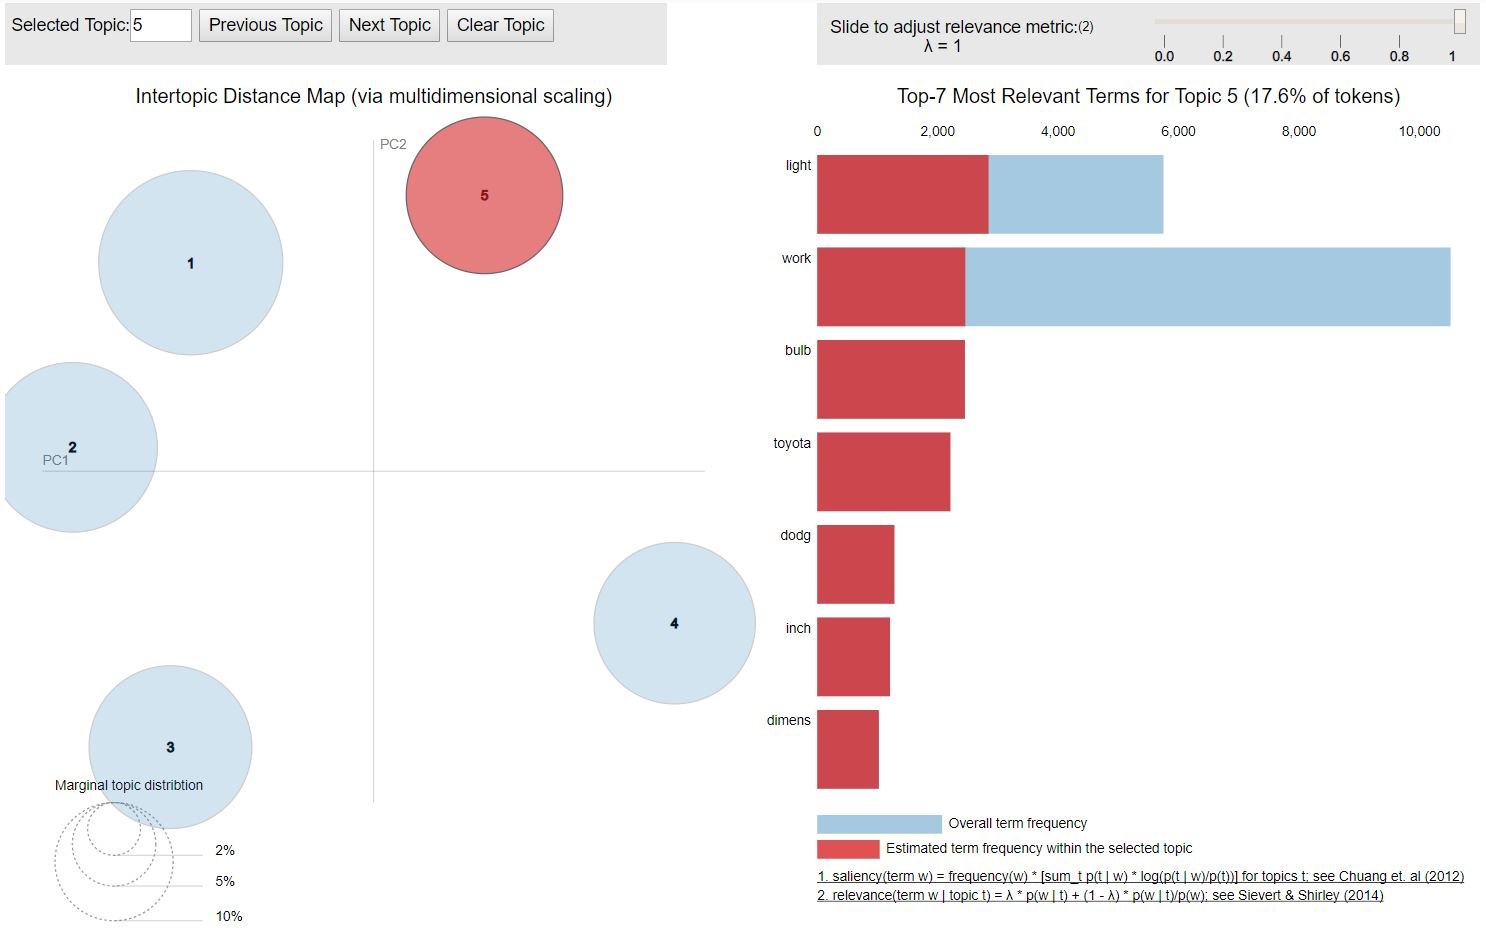

In [25]:
from IPython.display import Image
Image(filename='Visual.jpg', width=1100, height=700)

#### Step 10: Intepretation of topics obtained:

Now, let's try to identify the category of questions asked from the words provided for each topic:
1. Topic 1 (install, come, mount, wire, need, light, work) - **Installation**
2. Topic 2 (battery, say, unit, plug, light, power, charge) - **Battery & Charging**
3. Topic 3 (size, tire, need, color, order, black, know) - **Tire**
4. Topic 4 (work, seat, honda, model, chevi, ford, cover) - **Model specific**
5. Topic 5 (light, bulb, work, toyota, dodge, inch, dimension) - **Cannot deduce a valid topic** <br>

There are cases when the some of the topics obtained don't make much sense. One way to fix it would be to play around the hyperparameters in order to improve the results or sometimes its okay to just ignore them. Here, we can see that words in Topic 5 are not making much sense for categorizing it into specific category.